In [69]:
import os
import pandas as pd
import re
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
# Folder path to your CSV files
folder_path = './Data/'
file_names = os.listdir(folder_path)
dfs = []
for file_name in file_names:
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r', encoding='ISO-8859-2') as file:
            content = file.read()
        content = re.sub(r'\"(.*?)\"', lambda x: x.group(0).replace(',', '.'), content)
        cleaned_content = StringIO(content)
        df = pd.read_csv(cleaned_content, skiprows=17, encoding='ISO-8859-2')
        df = df[['Dátum', 'Árfolyam']]
        df['Dátum'] = pd.to_datetime(df['Dátum'], format='%Y/%m/%d')
        df = df.rename(columns={'Árfolyam': file_name.replace('.csv', '')})
        dfs.append(df)
merged_df = pd.concat(dfs, axis=1)
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
# print(merged_df)
df_trimmed = merged_df.dropna()


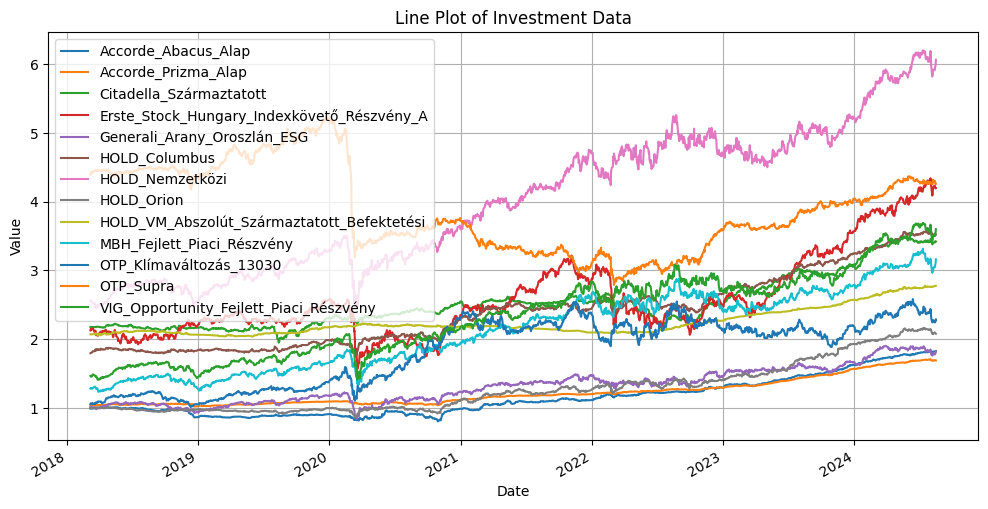

In [70]:
import matplotlib.pyplot as plt

df_trimmed.set_index('Dátum').plot(kind='line', figsize=(12, 6))
plt.title('Line Plot of Investment Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()


In [71]:
def load_yfinance_data(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data
last_date = df_trimmed['Dátum'].iloc[-1]

usdhuf = pd.DataFrame(load_yfinance_data('USDHUF=X', last_date, '2024-08-16'))
usdhuf.rename(columns={'Adj Close': 'USD/HUF'}, inplace=True)

usdhuf.reset_index(inplace=True)  
usdhuf['Date'] = pd.to_datetime(usdhuf['Date'])


[*********************100%%**********************]  1 of 1 completed


In [72]:

sp500 = pd.DataFrame(load_yfinance_data('SPY', last_date, '2024-08-16'))
sp500.reset_index(inplace=True)  
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500.rename(columns={'Adj Close': 'SP500'}, inplace=True)

df_trimmed['Dátum'] = pd.to_datetime(df_trimmed['Dátum'])

# Merge the dataframes on the date columns
df_combined = pd.merge(df_trimmed, sp500, left_on='Dátum', right_on='Date', how='left')
df_combined = df_combined.drop(columns=['Date'])
df_combined = pd.merge(df_combined, usdhuf, left_on='Dátum', right_on='Date', how='left')
df_combined = df_combined.drop(columns=['Date'])

df_combined['SP500'] = df_combined['SP500']*df_combined['USD/HUF']
df_combined_cleaned = df_combined.dropna()

df_combined_cleaned = df_combined.drop(columns=['USD/HUF'])
print(df_combined_cleaned.isna().any())



[*********************100%%**********************]  1 of 1 completed

Dátum                                         False
Accorde_Abacus_Alap                           False
Accorde_Prizma_Alap                           False
Citadella_Származtatott                       False
Erste_Stock_Hungary_Indexkövető_Részvény_A    False
Generali_Arany_Oroszlán_ESG                   False
HOLD_Columbus                                 False
HOLD_Nemzetközi                               False
HOLD_Orion                                    False
HOLD_VM_Abszolút_Származtatott_Befektetési    False
MBH_Fejlett_Piaci_Részvény                    False
OTP_Klímaváltozás_13030                       False
OTP_Supra                                     False
VIG_Opportunity_Fejlett_Piaci_Részvény        False
SP500                                          True
dtype: bool



C:\Users\takat\AppData\Local\Temp\ipykernel_34104\291056285.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['Dátum'] = pd.to_datetime(df_trimmed['Dátum'])


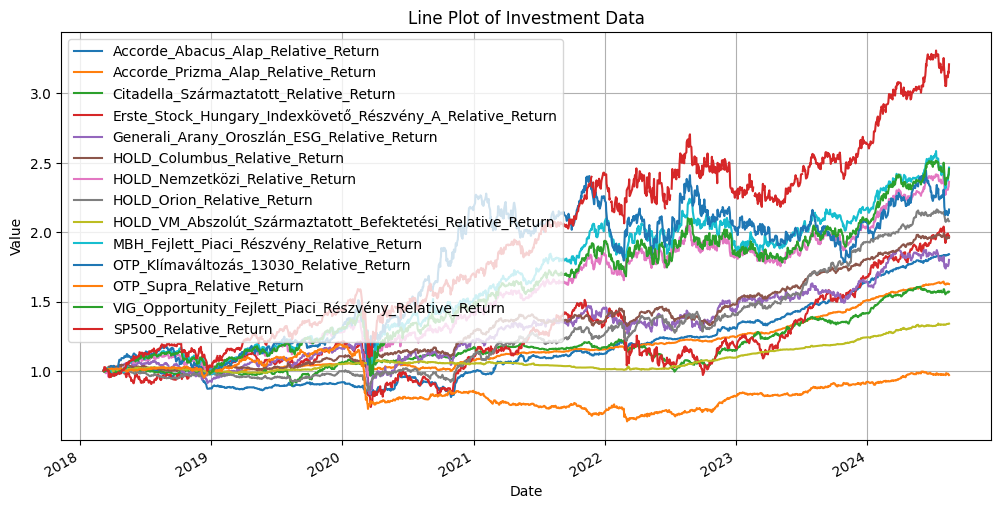

In [73]:
# Calculate relative returns
df_relative_returns = df_combined_cleaned.copy()
relative_return_columns = []

for column in df_relative_returns.columns[1:]:
    new_column = column + '_Relative_Return'
    relative_return_columns.append(new_column)
    df_relative_returns[new_column] = df_relative_returns[column] / df_relative_returns[column].iloc[-1]
import matplotlib.pyplot as plt

df_relative_returns[relative_return_columns + ['Dátum']].set_index('Dátum').plot(kind='line', figsize=(12, 6))
plt.title('Line Plot of Investment Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()


In [74]:
mate_df = df_relative_returns[relative_return_columns + ['Dátum']]


In [75]:
mate_df.to_csv("./Clean/clean-huf-spy-extended.csv")